In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


23.0


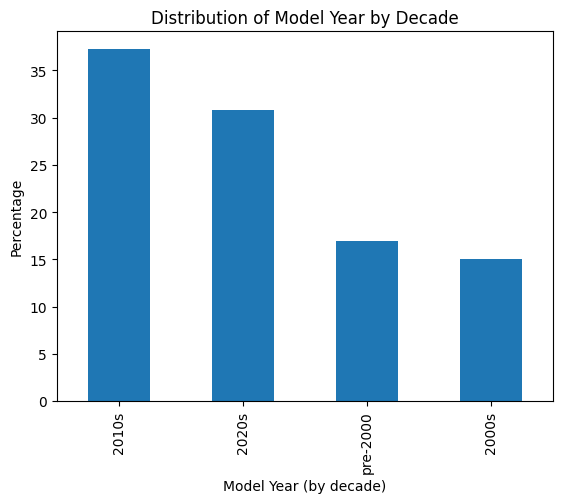

0      0
1      0
2      0
3      0
4      0
      ..
580    0
581    0
582    0
583    0
584    0
Name: Acura, Length: 585, dtype: int64

In [3]:
FILE_NAME = "doug_score.csv"
FILE_PATH = os.path.join(os.getcwd(), FILE_NAME)


def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(FILE_PATH)
    return df


df = load_data(FILE_PATH)

# one hot encoding of brand column 
df = pd.concat([df, pd.get_dummies(df["brand"], drop_first=False).astype(int)], axis=1)
# one hot encoding of model column 
df = pd.concat([df, pd.get_dummies(df["model_year"], drop_first=False).astype(int)], axis=1)

# model year groupings
def bin_4(x: int):
    if x >= 2020: 
        return "2020s"
    if  x < 2020 and x >= 2010:
        return "2010s"
    if  x < 2010 and x >= 2000:
        return "2000s"
    return "pre-2000"

def bin_3(x: int):
    if x >= 2020: 
        return "2020s"
    if  x < 2020 and x > 2000:
        return "2000s"
    if x <= 2000:
        return "pre-2000"

def bin_2(x: int):
    if x >= 2020: 
        return "modern"
    if  x < 2000:
        return "vintage"
df['model_year_10'] = df['model_year'].apply(lambda x: 10 * int(x / 10))
df['model_year_4'] = df['model_year'].apply(bin_4)
df['model_year_3'] = df['model_year'].apply(bin_3)
df['model_year_2'] = df['model_year'].apply(bin_2)

# Here we handle missing data for video link by setting the video length to the median as it will probably be the least biased
missing_video_value = df['video_link'].apply(lambda x:  int(x.split(":")[0]) if x and not pd.isna(x) else 0).median() 
print(missing_video_value)
# parse time here is in minutes so we can maybe get a better signal to make decisions on
df['video_link_m'] = df['video_link'].apply(lambda x:   int(x.split(":")[0]) if x and not pd.isna(x) else missing_video_value) 
# parse time from "mm:ss" to 10minute buckets this will help us group the data more separably 
# df['video_link_10']= df['video_link'].apply(lambda x: 10 * int(x.split(":")[0]/10))

# here we do a light mapping to split the category of vehicle country into specific world regions
COUNTRY_MAP= {
    'Germany': 'Germany',
    'USA': 'North-America',
    'Japan': 'Asia',
    'South Korea': 'Asia',
}
# Because the data set is skewed towards german cars we will split categorie into european, european non german, north american and asian cars
df['vehicle_region'] = df['vehicle_country'].apply(lambda x: COUNTRY_MAP.get(x, 'Other Europe'))

# here we translate doug socres into quintiles
df['doug_quantile'] = pd.qcut(df['dougscore'], q=5, labels=False)

# generate histogram by percentage
(df['model_year_4'].value_counts(normalize=True)*100).plot(kind='bar')
plt.xlabel('Model Year (by decade)')
plt.ylabel('Percentage')
plt.title('Distribution of Model Year by Decade')
plt.show()

#one hot encoding of the model years 
df = pd.concat([df, pd.get_dummies(df["model_year_10"], drop_first=False, prefix="my10").astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df["model_year_4"], drop_first=False, prefix="my4").astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df["model_year_3"], drop_first=False, prefix="my3").astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df["model_year_2"], drop_first=False, prefix="my2").astype(int)], axis=1)
df['Acura']


### Pearson Correlation for Fun factor, practicality, value


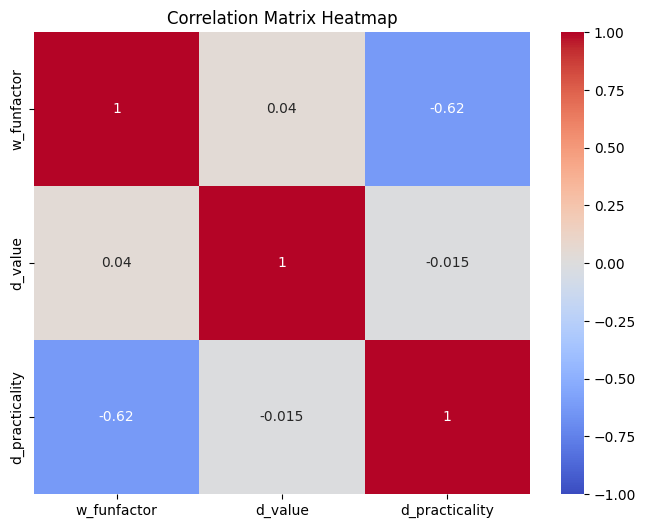

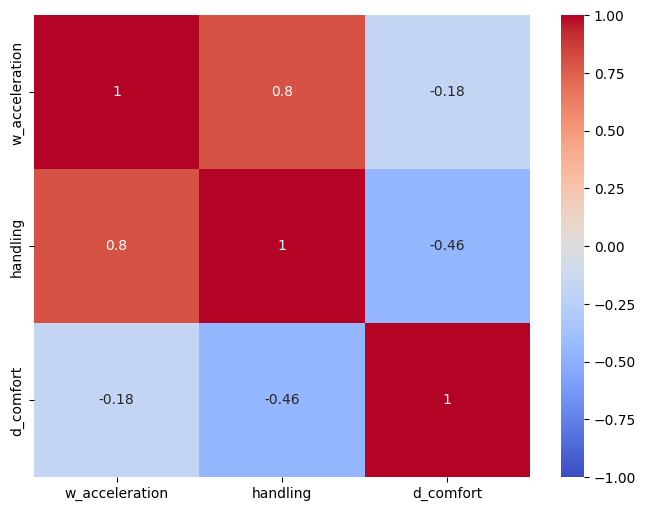

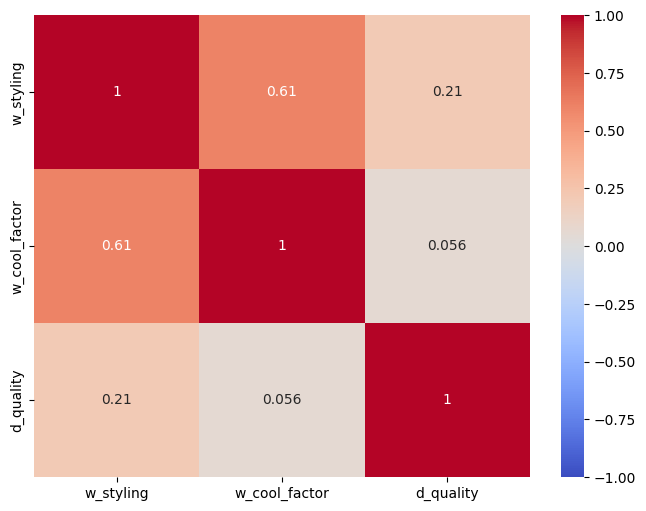

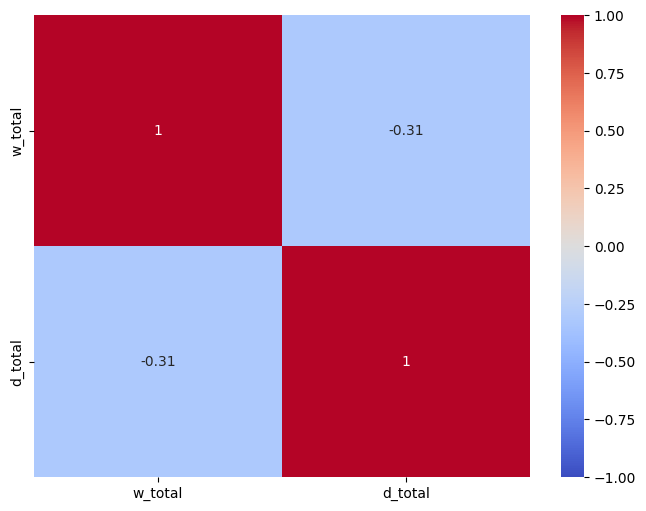

In [4]:

# overall the weekend factors seem to be only lightly or negatively correlated to the daily factors
# the sum of all the factors make a particular weekend or daily score so it makes some sense that the final score which is the sum of the 
# weekend and daily scores lands in the 70s if one of the other scores outweights the other , vs in the 90s 
# plt.show()
joint_columns = ["w_funfactor", "d_value", "d_practicality"]
new_df = pd.concat([df[col] for col in joint_columns],axis=1)

# calculate pairwise correlation
correlation_matrix = np.corrcoef(new_df, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=joint_columns, yticklabels=joint_columns)
plt.title('Correlation Matrix Heatmap')

joint_columns = ["w_acceleration", "handling", "d_comfort"]
new_df = pd.concat([df[col] for col in joint_columns],axis=1)

# calculate pairwise correlation
correlation_matrix = np.corrcoef(new_df, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=joint_columns, yticklabels=joint_columns)
plt.show()

# Styl0ng, cool factor, quality
joint_columns = ["w_styling", "w_cool_factor", "d_quality"]
new_df = pd.concat([df[col] for col in joint_columns],axis=1)

# calculate pairwise correlation
correlation_matrix = np.corrcoef(new_df, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=joint_columns, yticklabels=joint_columns)
plt.show()

# Styl0ng, cool factor, quality
# Weekend score, daily score, brand

joint_columns = ["w_total", "d_total"]
new_df = pd.concat([df[col] for col in joint_columns],axis=1)

# calculate pairwise correlation for weekend and daily score
correlation_matrix = np.corrcoef(new_df, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=joint_columns, yticklabels=joint_columns)
plt.show()


In [5]:
# a regression model for the affect of brand on the weekend score
import statsmodels.api as sm
from statsmodels.formula.api import ols

# create a model for the weekend score
joint_columns = []
# joint_columns.extend(["w_total"])
joint_columns.extend(df['brand'].unique())
X = sm.add_constant(df[joint_columns])
y = df["d_total"]
model = sm.OLS(y, X).fit()
print("Daily total score Adjusted. R-squared", model.rsquared_adj)
# here we say brand explains 45.9% of the variation in the daily score

# I also applied brand with the weekend score, but it accounted for a very small percentage 2% change in the r^2 value
y = df['w_total']
X = sm.add_constant(df[joint_columns])
model = sm.OLS(y, X).fit()
print("Weekend total score Adjusted. R-squared", model.rsquared_adj)

# in this case brand accounted for 49% of the variation in the weekend score
# and in the case of the daily score it accounted for 34.4% 

# This leads us to conclude that brand does matter in the weekend score, but not as much as the daily score 



Daily total score Adjusted. R-squared 0.34476332916618013
Weekend total score Adjusted. R-squared 0.49016770728384407


In [6]:
# Weekend score, daily score, model year
# create a model for the weekend score
from statsmodels.regression.linear_model import RegressionResultsWrapper

# Here we regress across the different buckets for model year , the decade model, the 4 bucket model, and the 3 bucket model
daily = df["d_total"]
weekend = df["w_total"]

def get_model_year_regression(df: pd.DataFrame, y, model_year_prefix: str, model_year_column)-> RegressionResultsWrapper :
    joint_columns = df['model_year'].unique()
    if(model_year_prefix != ""):
        joint_columns =model_year_column.apply(lambda x: model_year_prefix + "_" + str(x)).unique()
    X = sm.add_constant(df[joint_columns])
    model = sm.OLS(y, X).fit()
    return model

print("Daily Score Model Year Regression")
print("Rsquared for by model year", get_model_year_regression(df, daily, "", df['model_year']).rsquared)
print("Rsquared for by decade grouping", get_model_year_regression(df, daily, "my10", df["model_year_10"]).rsquared)
print("Rsquared for by 2020s 2010s  2000s pre-2000s grouping", get_model_year_regression(df, daily, "my4", df["model_year_4"]).rsquared)
print("Rsquared for by 2020s 2000s pre-2000s grouping", get_model_year_regression(df, daily, "my3", df["model_year_3"]).rsquared)
# print("Rsquared for by modern vintage grouping", get_model_year_regression(df, daily, "my2", df["model_year_2"]).rsquared)

print("\nWeekend Score Model Year Regression")
print("Rsquared for by model year", get_model_year_regression(df, weekend, "", df['model_year']).rsquared)
print("Rsquared for by decade grouping", get_model_year_regression(df, weekend, "my10", df["model_year_10"]).rsquared)
print("Rsquared for by 2020s 2010s  2000s pre-2000s grouping", get_model_year_regression(df, weekend, "my4", df["model_year_4"]).rsquared)
print("Rsquared for by 2020s 2000s pre-2000s grouping", get_model_year_regression(df, weekend, "my3", df["model_year_3"]).rsquared)
# print("Rsquared for by modern vintage grouping", get_model_year_regression(df, weekend, "my2", df["model_year_2"]).rsquared)

# joint_columns.extend(["w_total"])

#there was 46.2%  explaination in change in the daily score

#there was 10.0%  explaination in change in the weekend score

Daily Score Model Year Regression
Rsquared for by model year 0.465845253275877
Rsquared for by decade grouping 0.3610961787201846
Rsquared for by 2020s 2010s  2000s pre-2000s grouping 0.351359530865307
Rsquared for by 2020s 2000s pre-2000s grouping 0.2948857650852982

Weekend Score Model Year Regression
Rsquared for by model year 0.09960770608515956
Rsquared for by decade grouping 0.04532780409410009
Rsquared for by 2020s 2010s  2000s pre-2000s grouping 0.03928422417333721
Rsquared for by 2020s 2000s pre-2000s grouping 0.036448756841226615


In [215]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import matplotlib.pyplot as plt
import shap
import re

def train_and_plot_tree(df, 
                        daily_columns=[], 
                        weekend_columns=[], 
                        meta_columns=[], 
                        criteria=None, 
                        quantile=5,
                        tree_depth=5,
                        show_plot=True):
    
    filtered_df = df
    # Apply criteria if provided
    if criteria:
        filtered_df = df[criteria(df)]

    # Combine the columns
    active_columns = []
    active_columns.extend(daily_columns)
    active_columns.extend(weekend_columns)
    active_columns.extend(meta_columns)

    # Preprocess data
    X = filtered_df[active_columns]
    X.reset_index(drop=True, inplace=True)
    cat_features = meta_columns
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X[cat_features])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))
    X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
    filtered_df['doug_quantile'] = pd.qcut(df['dougscore'], q=quantile, labels=False)
    y = filtered_df['doug_quantile']
    # Train the decision tree
    clf = DecisionTreeClassifier(max_depth=tree_depth, criterion='gini', random_state=42, min_samples_leaf=10, min_samples_split=10)
    
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(clf, X, y, cv=stratified_kfold, return_train_score=True)
    
    print('Training scores:', cv_results['train_score'])
    print('Validation scores:', cv_results['test_score'])
    print('Mean training score:', cv_results['train_score'].mean())
    print('Mean validation score:', cv_results['test_score'].mean())
    
    clf.fit(X, y)
    shap.initjs()
    explainer = shap.TreeExplainer(clf)#.shap_values(df[daily + weekend + meta])
    # Compute SHAP values for the first instance in the dataset

    # Compute SHAP values for all instances in the dataset
    shap_values = explainer.shap_values(X)

    # Compute the mean absolute SHAP values for each feature for each class
    class_names_dict= {2: ['Bad', 'Good'], 3: ['Bad', 'Average', 'Good'], 5: [
        'Poor', 'Below Average', 'Average', 'Above Average', 'Good'
    ]}
    class_names = class_names_dict[len(shap_values)]  # replace with your actual class names
    feature_names=X.columns.map(lambda x: re.sub("^\w_", "",x))
    # Visualize the summary of SHAP values with a summary plot
    if show_plot:
        shap.summary_plot(shap_values, X, feature_names=feature_names, max_display=5, class_names=class_names)
        plt.show()
    N = 8  

    from scipy.stats import kstest
    # Get the SHAP values for class 0
    print(np.shape(shap_values[1]))
    shap_values_class_0 = shap_values[1]

    # Flatten the SHAP values to a 1D array
    shap_values_class_0 = shap_values_class_0

    # Standardize the SHAP values to have mean 0 and variance 1
    shap_values_class_0 = (shap_values_class_0 - np.mean(shap_values_class_0)) / np.std(shap_values_class_0)

    # Perform the Kolmogorov-Smirnov test
    for i in range(len(shap_values_class_0[0])):
        stat, p = kstest(shap_values_class_0[i], 'norm')
        print('Statistics=%.3f, p=%.10f' % (stat, p)) 

    from scipy.stats import kurtosis

    print(np.shape(shap_values_class_0))
    data_kurtosis = kurtosis(shap_values_class_0, axis=0)
    print("kurtosis data",data_kurtosis)

    plt.hist(shap_values_class_0, bins=20)
    plt.show()


    # For each class
    for i in range(len(shap_values)):
        # Compute the mean absolute SHAP values for each feature
        mean_shap_values = np.mean(np.abs(shap_values[i]), axis=0)
        # Get the indices of the top n features
        top_n_indices = np.argsort(mean_shap_values)[-N:]
        # Get the mean SHAP values for the top n features
        top_n_mean_shap_values = mean_shap_values[top_n_indices]
        # Compute the relative importance of each feature
        relative_importance = top_n_mean_shap_values / np.sum(top_n_mean_shap_values)
        # Create a pie chart
        plt.figure()
        plt.pie(relative_importance, labels=feature_names[top_n_indices], autopct='%1.1f%%',colors=plt.cm.Set3(np.arange(len(X.columns[top_n_indices]))))
        plt.title(f'Relative Feature Importance - {class_names[i]}')
        if show_plot:
            plt.show()
    #shap.dependence_plot("w_acceleration", shap_values[2], X)

    # Plot the tree
    if show_plot:
        plt.figure(figsize=(80,40))
        plot_tree(clf, feature_names=list(X.columns), class_names=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], filled=True)
        plt.show()
    # Compute SHAP values
    # For each class
    for i in range(len(shap_values)):
        print(f'Median shapely value: for {class_names[i]} Cars:')
        # Compute average SHAP values for each feature
        avg_shap_values = np.mean(shap_values[i], axis=0)
        # Print the average SHAP values
        for feature, value in zip(X.columns, avg_shap_values):
            f_name = re.sub("^\w_","",feature)
            print(f'{f_name}: {value}') 
    return clf

Training scores: [0.92735043 0.92948718 0.92307692 0.93589744 0.9508547 ]
Validation scores: [0.91452991 0.88034188 0.91452991 0.94871795 0.90598291]
Mean training score: 0.9333333333333333
Mean validation score: 0.9128205128205128


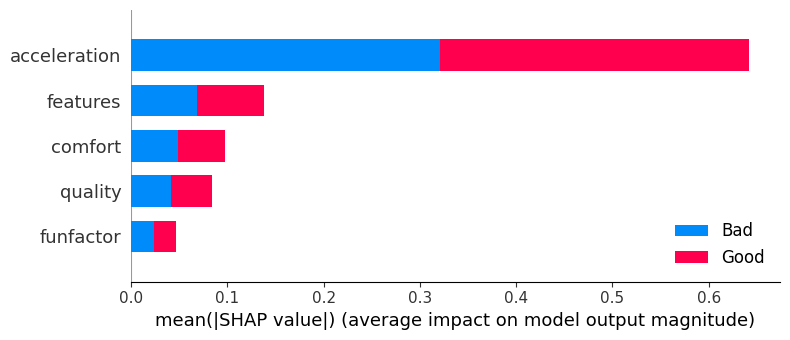

(585, 10)
Statistics=0.390, p=0.0703036988
Statistics=0.300, p=0.2689894902
Statistics=0.500, p=0.0077774100
Statistics=0.461, p=0.0182494619
Statistics=0.481, p=0.0118286168
Statistics=0.461, p=0.0182494619
Statistics=0.390, p=0.0703036988
Statistics=0.390, p=0.0703036988
Statistics=0.390, p=0.0703036988
Statistics=0.390, p=0.0703036988
(585, 10)
kurtosis data [ 2.35630106 -2.         -2.         11.73153736 12.07066676 -1.64104902
  9.60636616  3.8039876  15.90186659  7.66921214]


Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


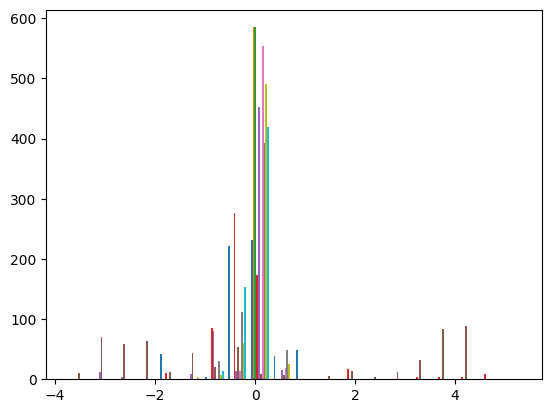

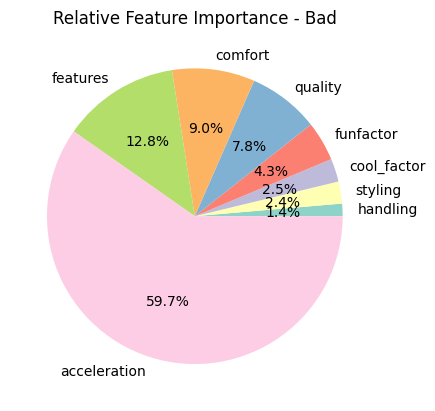

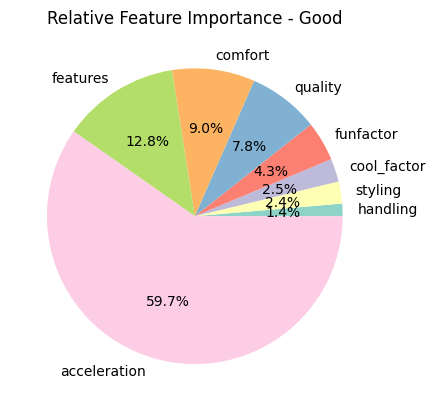

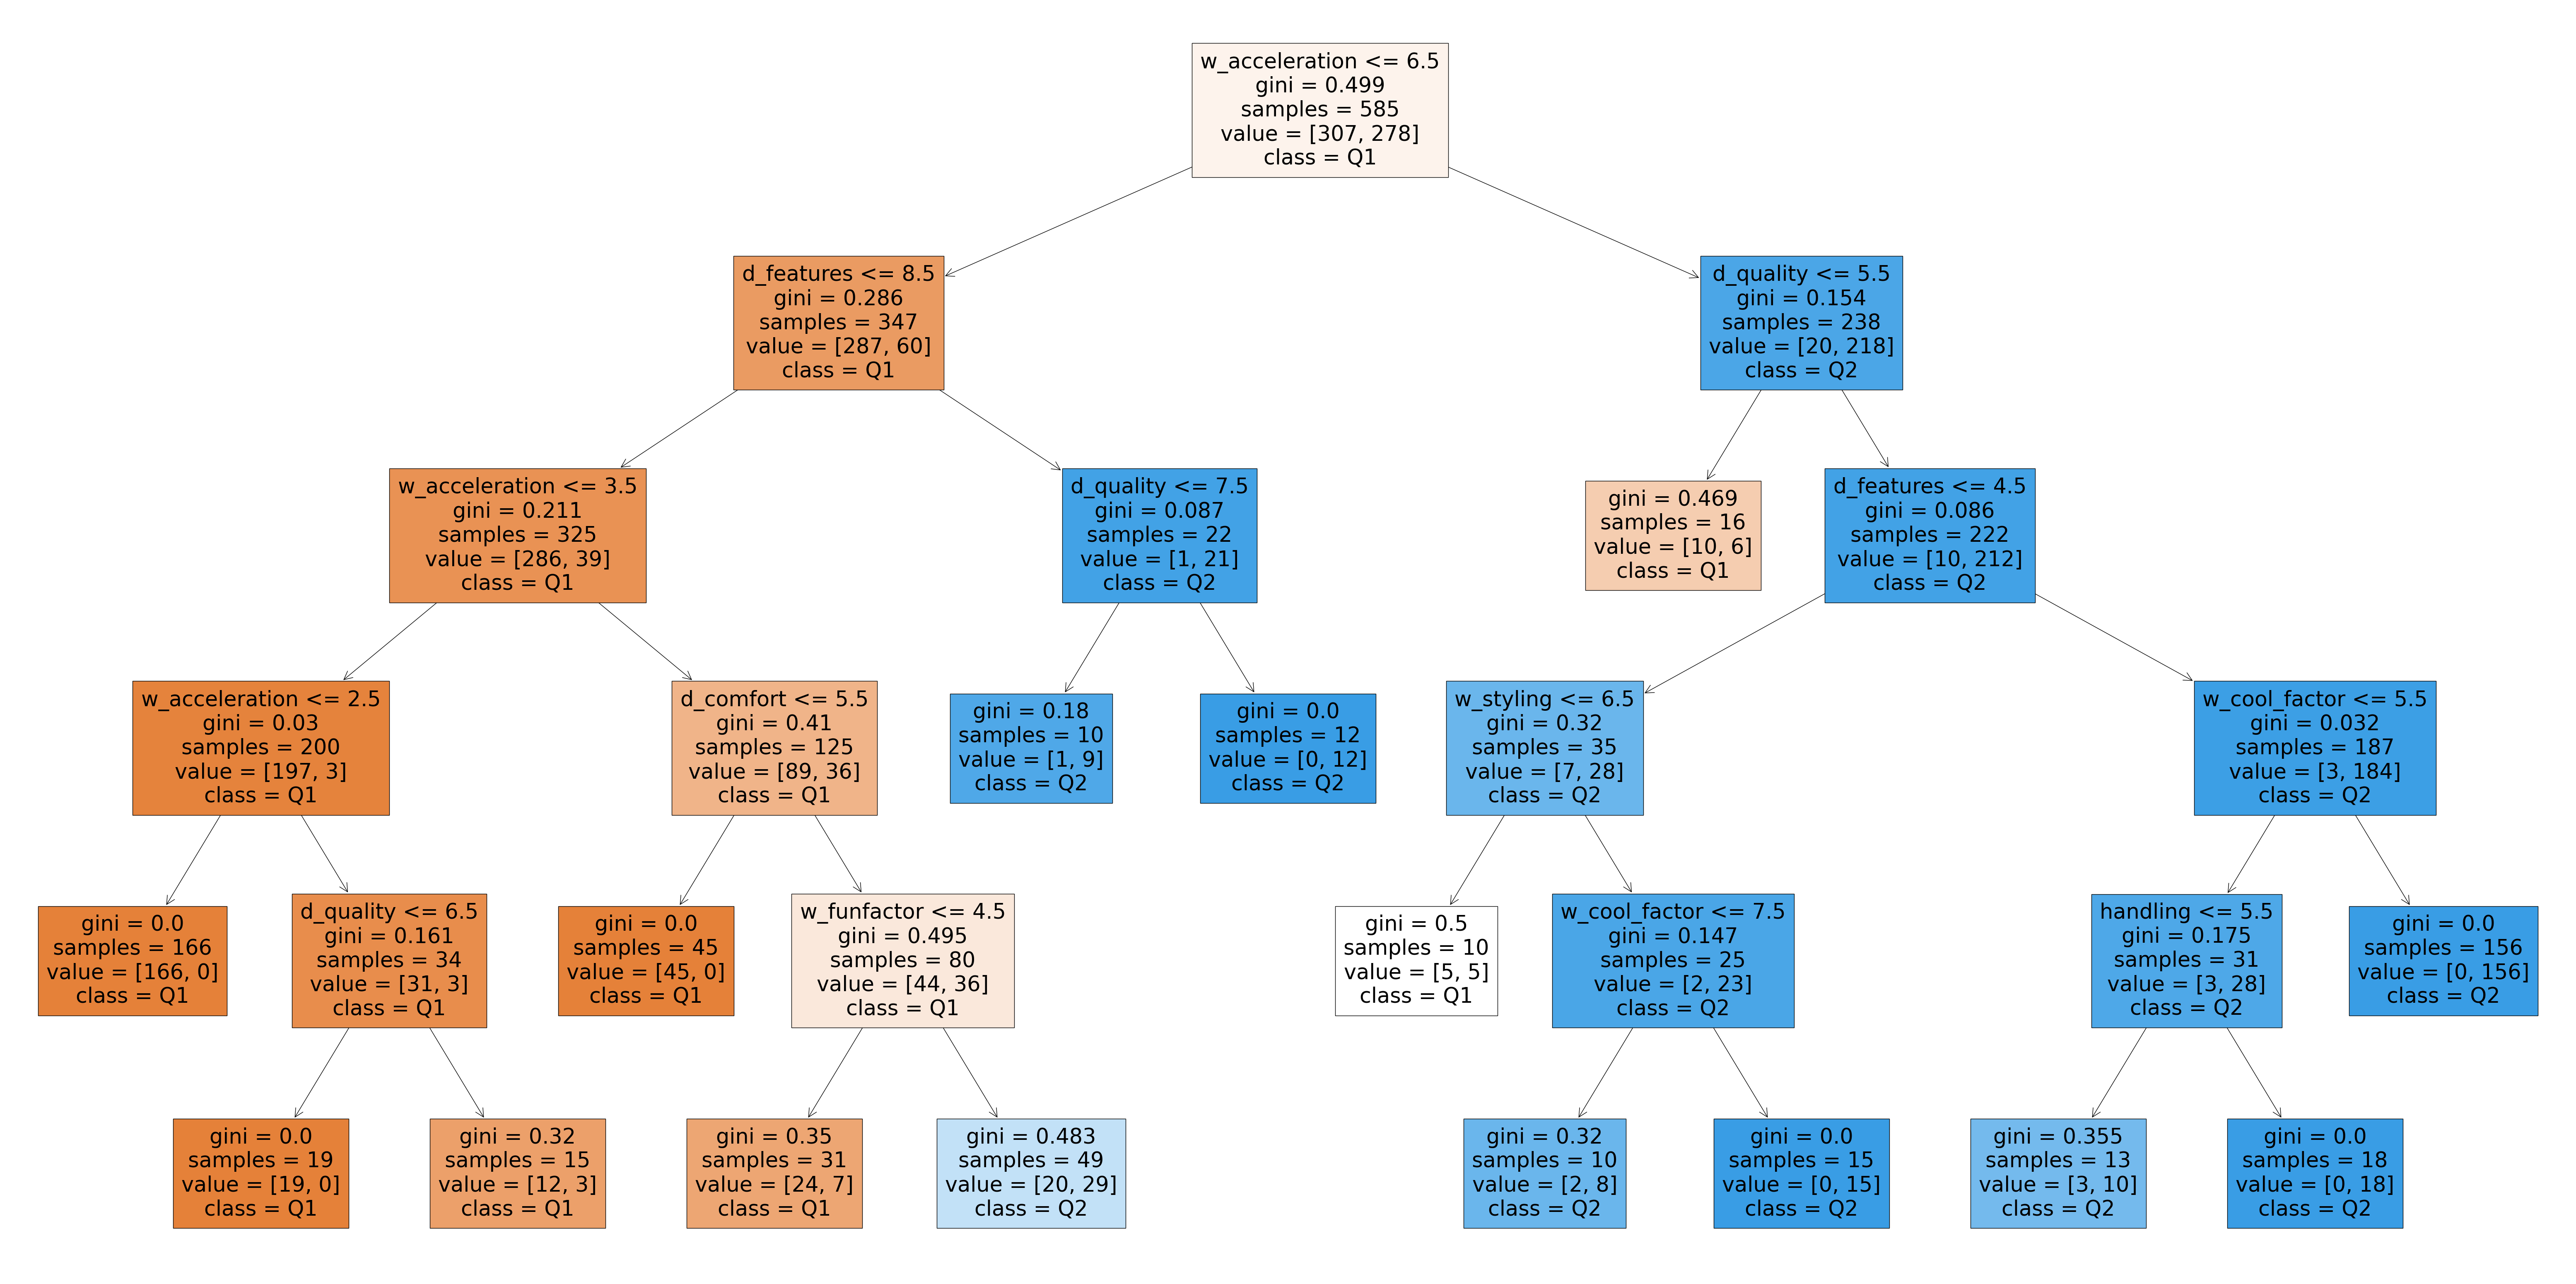

Median shapely value: for Bad Cars:
comfort: 0.007171801851664536
practicality: 0.0
value: 0.0
features: 0.008804195548288324
quality: 0.010606952076922927
acceleration: -0.039771116662729304
handling: 0.0015959367465532726
funfactor: -0.0012694524876331154
styling: 0.004554804929621181
cool_factor: 0.008306877997312643
Median shapely value: for Good Cars:
comfort: -0.007171801851664536
practicality: 0.0
value: 0.0
features: -0.008804195548288303
quality: -0.010606952076922938
acceleration: 0.039771116662729214
handling: -0.0015959367465532748
funfactor: 0.0012694524876331154
styling: -0.004554804929621183
cool_factor: -0.008306877997312646


In [216]:

# Example usage
daily = ['d_comfort', 'd_practicality', 'd_value', 'd_features', 'd_quality']
weekend = ['w_acceleration', 'handling', 'w_funfactor', 'w_styling', 'w_cool_factor']
# meta = ['brand', 'film_region', 'film_country', 'vehicle_region','model_year','video_link_m']
meta = [] #['model_year']

# Criteria example: Only consider rows where 'd_comfort' is greater than 5
criteria_func = None # lambda df: df['vehicle_region'] == "Germany" 
# Call the function and filter the dataframe
tree = train_and_plot_tree(df, daily_columns=daily, weekend_columns=weekend, meta_columns=meta, criteria=criteria_func,quantile=2, tree_depth=5)



vehicle_region
Germany          167
Other Europe     165
North-America    128
Asia             125
Name: count, dtype: int64
Training scores: [0.87393162 0.85042735 0.84188034 0.85470085 0.84188034]
Validation scores: [0.81196581 0.81196581 0.81196581 0.83760684 0.76068376]
Mean training score: 0.8525641025641025
Mean validation score: 0.8068376068376069


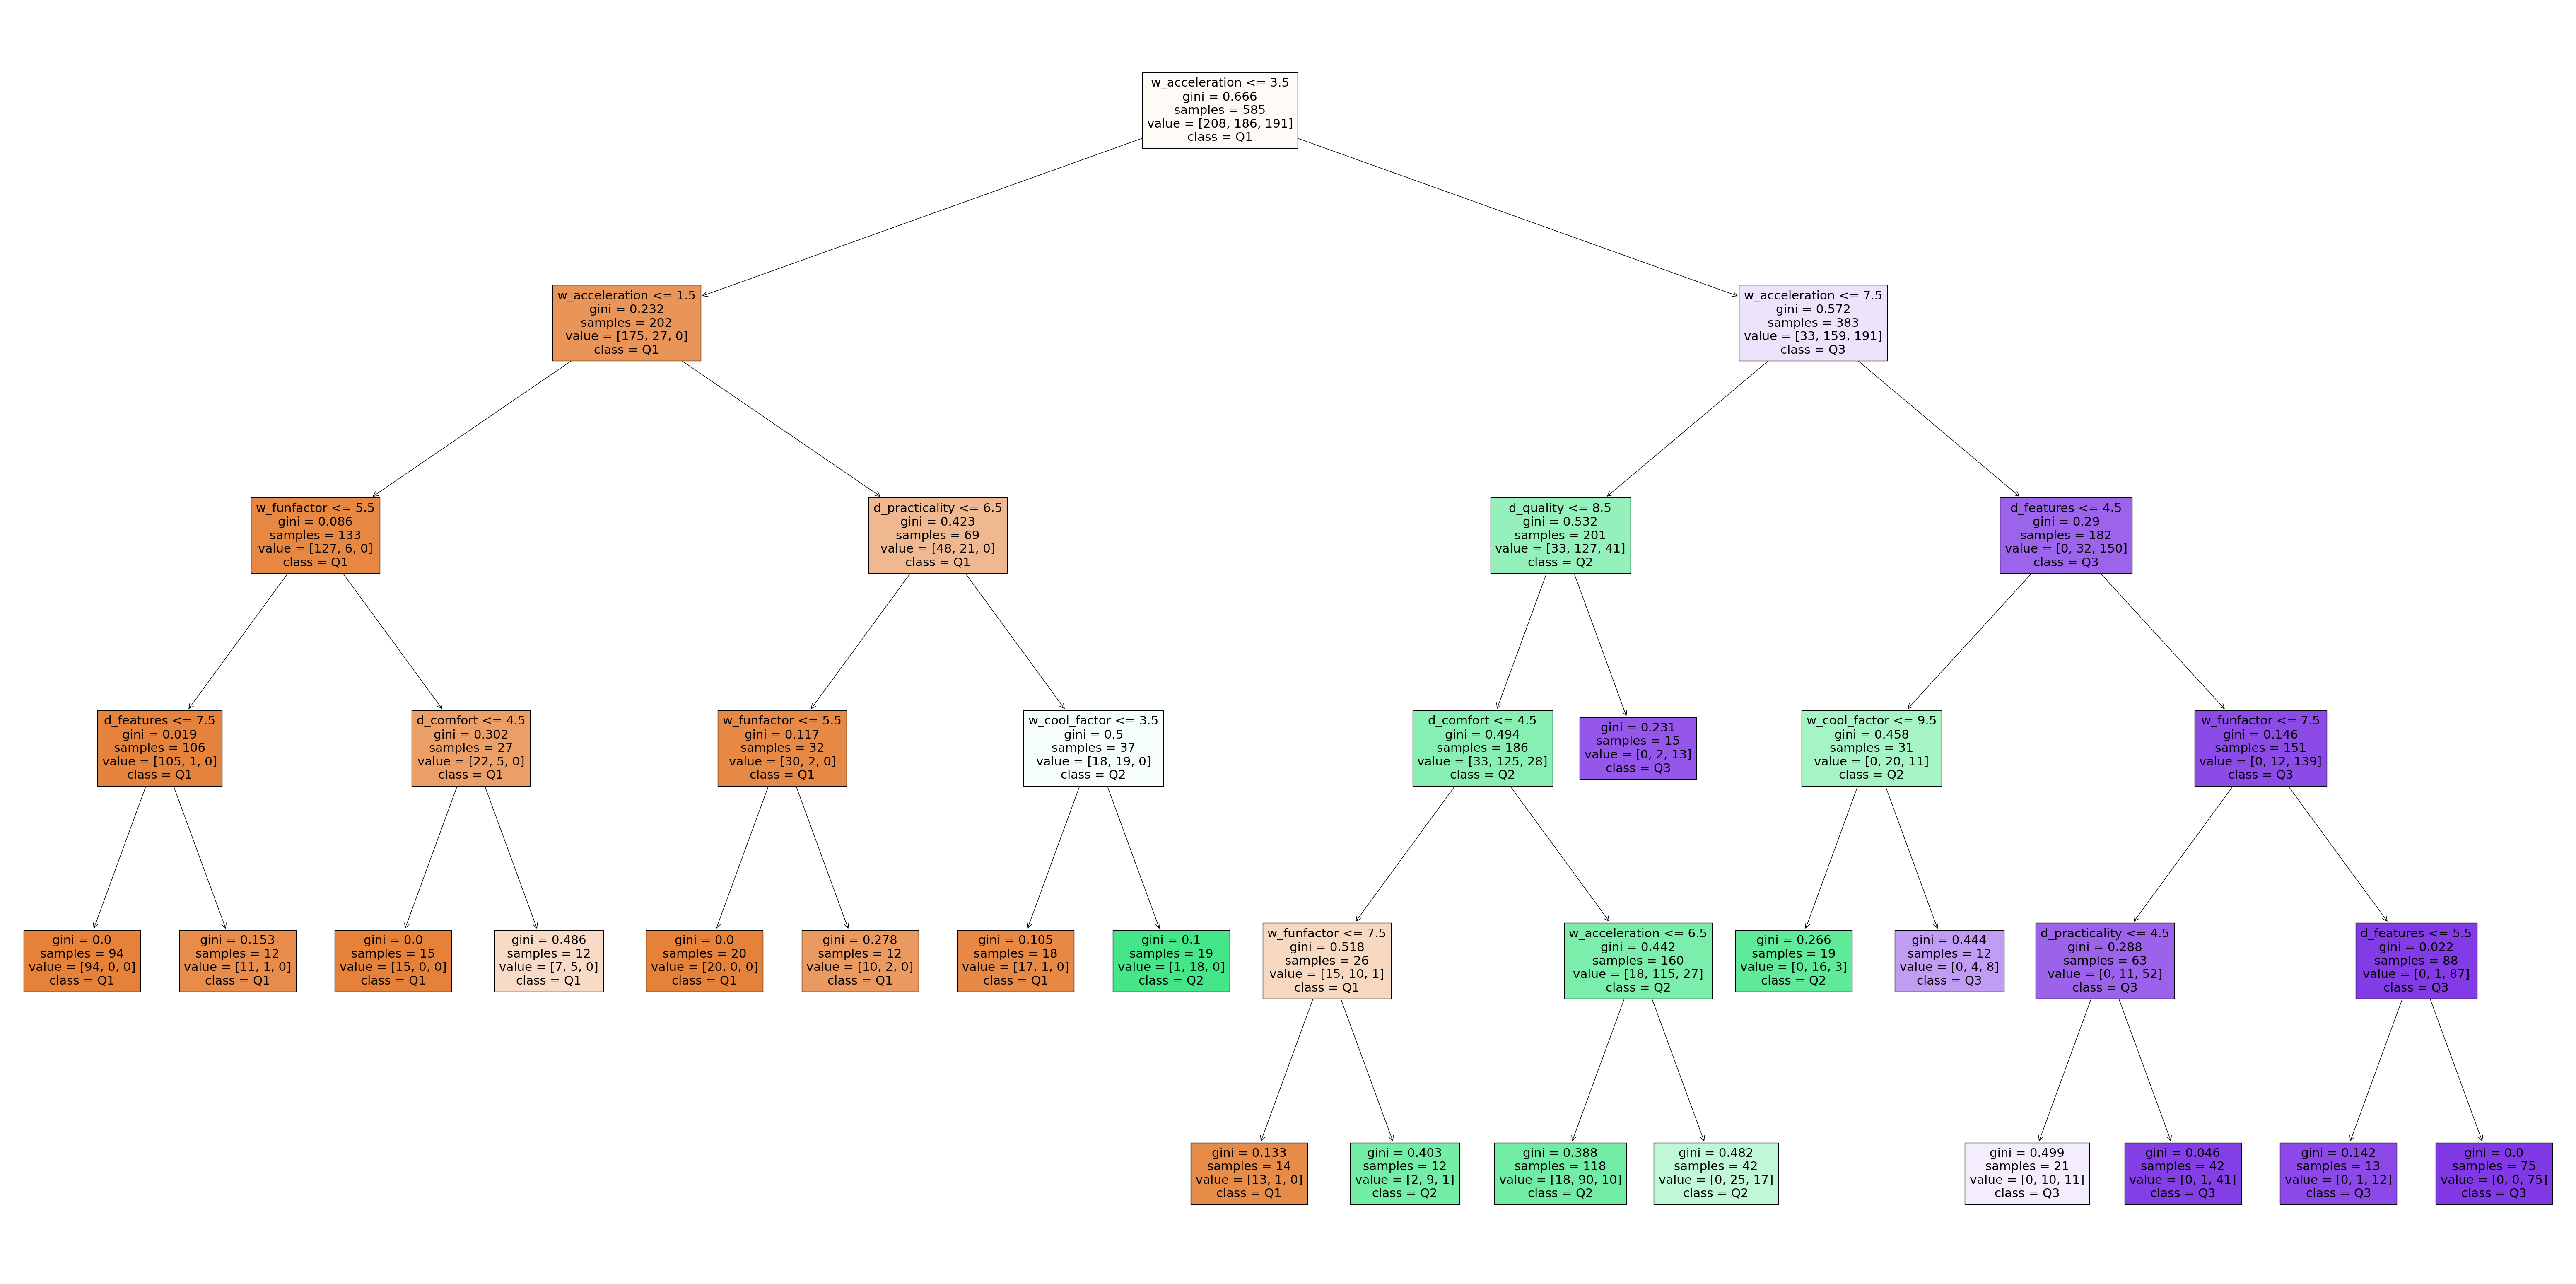

In [9]:

from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

# here we're taking a look at the splitting up the doug score into categories binning it into quintiles
# this will allow us to see the distribution of the doug score to predict the quintile bottom 20%, to top 20% of cars
# we can also extend this to decile
df[['dougscore','w_total','d_total']]
df[['d_comfort','d_total','d_practicality','d_value','d_features','d_quality']]
df[['handling','w_acceleration','w_funfactor','w_styling','w_cool_factor', 'w_total']]
df[['brand','film_region','film_country','vehicle_country']]

# capture this
# df['vehicle_country'].value_counts()
# df['doug_quantile']=df[['dougscore']].quantile([0.2,0.4,0.6,0.8,1.0])
# here we translate into quintiles
df['doug_quantile'] = pd.qcut(df['dougscore'], q=3, labels=False)





# nice to see the quantlies by year
df[['doug_quantile','brand', 'model_year']].sort_values(by=['doug_quantile','model_year'], ascending=False)

# here we translate vehicle_country to vehicle region 


print(df['vehicle_region'].value_counts())
filtered_columns_daily =['d_comfort','d_practicality','d_value','d_features','d_quality']
filtered_columns_weekend =['w_acceleration','handling','w_funfactor','w_styling','w_cool_factor']
filtered_columns_meta=['brand','film_region','film_country','vehicle_region']




active_columns = []
active_columns.extend(filtered_columns_daily)
active_columns.extend(filtered_columns_weekend)
active_columns.extend(filtered_columns_meta)



X = df[active_columns]
cat_features = filtered_columns_meta # ['brand', 'film_region', 'film_country', 'vehicle_region']
# One-hot encode the categorical features

# One-hot encode the categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X[filtered_columns_meta])
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))

# Combine the one-hot encoded columns with the numeric columns
X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
y = df['doug_quantile'] 



# Create a decision tree classifier and fit it to the data
clf = DecisionTreeClassifier(max_depth=5,criterion='gini', random_state=42, min_samples_split=10, min_samples_leaf=10)  # Limiting depth for visualization purposes
# Perform 5-fold cross-validation on the decision tree classifier
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(clf, X, y, cv=stratified_kfold, return_train_score=True)
# Print the cross-validation results
print('Training scores:', cv_results['train_score'])
print('Validation scores:', cv_results['test_score'])
print('Mean training score:', cv_results['train_score'].mean())
print('Mean validation score:', cv_results['test_score'].mean())

clf.fit(X, y)


# Map the one-hot encoded columns back to the original categorical values
X_decoded = encoder.inverse_transform(X_encoded)
X_decoded_df = pd.DataFrame(X_decoded, columns=cat_features)

# Visualize the decision tree
plt.figure(figsize=(80,40))
plot_tree(clf, feature_names=list(X.columns), class_names=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], filled=True)
#plt.show()

# I tried removing category data and only gained marginal improvement in the model

# Extract the decision paths for each target class
path_indicator = clf.decision_path(X)
path_indicator_csr = path_indicator.tocsr()
paths = []
for i in range(clf.n_classes_):
    paths.append(path_indicator_csr[:, clf.tree_.children_left[0]:clf.tree_.children_right[0]].toarray())

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
import pandas as pd

def train_random_forest(df, 
                        daily_columns=[], 
                        weekend_columns=[], 
                        meta_columns=[], 
                        criteria=None, 
                        tree_depth=7, 
                        quantile=5,
                        n_trees=100):
    
    # Apply criteria if provided
    filtered_df = df
    if criteria:
        filtered_df = df[criteria(df)]

    # Combine the columns
    active_columns = []
    active_columns.extend(daily_columns)
    active_columns.extend(weekend_columns)
    active_columns.extend(meta_columns)

    # Preprocess data
    X = filtered_df[active_columns]
    cat_features = meta_columns
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X[cat_features])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))
    X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
    filtered_df['doug_quantile'] = pd.qcut(df['dougscore'], q=quantile, labels=False)
    y = filtered_df['doug_quantile']

    # Train the random forest
    clf = RandomForestClassifier(n_estimators=n_trees, max_depth=tree_depth, random_state=42, min_samples_leaf=10, min_samples_split=10)

    cv_results = cross_validate(clf, X, y, cv=5, return_train_score=True)
    
    print('Training scores:', cv_results['train_score'])
    print('Validation scores:', cv_results['test_score'])
    print('Mean training score:', cv_results['train_score'].mean())
    print('Mean validation score:', cv_results['test_score'].mean())
    
    clf.fit(X, y)

    shap.initjs()
    explainer = shap.TreeExplainer(clf)#.shap_values(df[daily + weekend + meta])
    # Compute SHAP values for the first instance in the dataset

    # Compute SHAP values for all instances in the dataset
    shap_values = explainer.shap_values(X)

    # Visualize the summary of SHAP values with a summary plot
    shap.summary_plot(shap_values, X)
    plt.show()   
    return clf

Training scores: [0.92094017 0.89102564 0.87820513 0.87393162 0.94444444]
Validation scores: [0.60683761 0.87179487 0.94871795 0.8034188  0.70940171]
Mean training score: 0.9017094017094017
Mean validation score: 0.7880341880341881


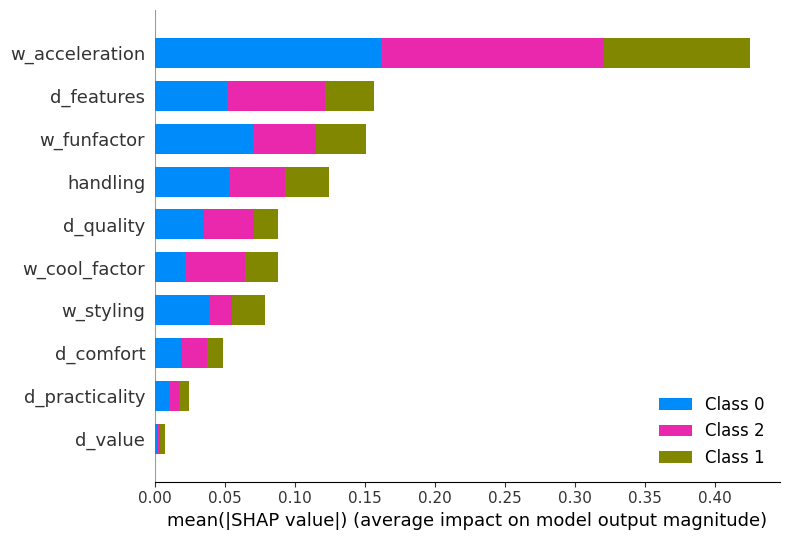

In [82]:

from sklearn.ensemble import RandomForestClassifier
# here we amplify our data by creating a random forest approach as a classifier to understand it better
# the earlier tree maxed out at 7 levels of depth and was only able to validate at about 0.64 which is not great
# here we try to amplify the data by using a random forest approach to learn different aspects of the data and then 
# create a classifier to understand it better the relationships between the data points


## Ranodm Forest
"""
# Create a random forest classifier and fit it to the data
clf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
# Perform 5-fold cross-validation
cv_results = cross_validate(clf, X, y, cv=5, return_train_score=True)
# Print the cross-validation results
print('Training scores:', cv_results['train_score'])
print('Validation scores:', cv_results['test_score'])
print('Mean training score:', cv_results['train_score'].mean())
print('Mean validation score:', cv_results['test_score'].mean())
"""
# Example usage
daily = ['d_comfort', 'd_practicality', 'd_value', 'd_features', 'd_quality']
weekend = ['w_acceleration', 'handling', 'w_funfactor', 'w_styling', 'w_cool_factor']
meta = [] #['model_year', 'vehicle_region'] #['brand', 'film_region', 'film_country', 'vehicle_region']

# Criteria example: Only consider rows where 'd_comfort' is greater than 5
criteria_func = lambda df: df['d_comfort'] > 0

# Call the function
forest = train_random_forest(df, daily_columns=daily, weekend_columns=weekend, meta_columns=meta, criteria=criteria_func, tree_depth=5,quantile=3, n_trees=100)

#plt.figure(figsize=(80,40))
#plot_tree(forest, feature_names=list(X.columns), class_names=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], filled=True)
#plt.show()


In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
import pandas as pd

def train_gradient_boost_tree(df, 
                              daily_columns=[], 
                              weekend_columns=[], 
                              meta_columns=[], 
                              criteria=None, 
                              tree_depth=7, 
                              quantile=5,
                              n_estimators=1000,
                              learning_rate=0.01):
    
    # Apply criteria if provided
    filtered_df = df
    if criteria:
        filtered_df = df[criteria(df)]

    # Combine the columns
    active_columns = []
    active_columns.extend(daily_columns)
    active_columns.extend(weekend_columns)
    active_columns.extend(meta_columns)

    # Preprocess data
    X = filtered_df[active_columns]
    cat_features = meta_columns
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X[cat_features])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_features))
    X = pd.concat([X.drop(cat_features, axis=1), X_encoded_df], axis=1)
    filtered_df['doug_quantile'] = pd.qcut(df['dougscore'], q=quantile, labels=False)
    y = filtered_df['doug_quantile']

    # Train the gradient boosting tree
    gbc = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=tree_depth, random_state=42)
    cv_results = cross_validate(gbc, X, y, cv=5, return_train_score=True)
    
    print('Training scores:', cv_results['train_score'])
    print('Validation scores:', cv_results['test_score'])
    print('Mean training score:', cv_results['train_score'].mean())
    print('Mean validation score:', cv_results['test_score'].mean())
    
    gbc.fit(X, y)
    
    return gbc
train_gradient_boost_tree(df, daily_columns=daily, weekend_columns=weekend, meta_columns=meta, criteria=criteria_func, tree_depth=5,quantile=2, n_estimators=200, learning_rate=0.01)

# plt.show()

Training scores: [1.         0.99358974 0.9957265  0.9957265  0.99358974]
Validation scores: [0.76068376 0.95726496 1.         0.92307692 0.76923077]
Mean training score: 0.9957264957264957
Mean validation score: 0.8820512820512821


GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=200,
                           random_state=42)